In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging

import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.evaluation import eval_net
from torchsummary import summary
from torch_unet.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25

val_percent = 0.2
batch_size=1
lr = 0.01
img_scale = 1
epochs = 3

In [3]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, mask_threshold=MASK_THRESHOLD, input_height=400, output_height=400)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

INFO: Creating dataset with 100 examples


In [4]:
# Register device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net = UNet(n_channels=3, n_classes=1, depth=5, padding=True)
net.to(device=device);

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

INFO: Using device cpu


In [6]:
output_size = net(torch.randn(1, 3, 400, 400))

torch.Size([1, 512, 50, 50]) torch.Size([1, 512, 50, 50])
torch.Size([1, 256, 100, 100]) torch.Size([1, 256, 100, 100])
torch.Size([1, 128, 200, 200]) torch.Size([1, 128, 200, 200])
torch.Size([1, 64, 400, 400]) torch.Size([1, 64, 400, 400])


In [15]:
output_size.shape

torch.Size([1, 1, 400, 400])

In [6]:
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
criterion = nn.BCEWithLogitsLoss()

In [7]:
for epoch in range(epochs):
    net.train()   # Sets module in training mode
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
            
            masks_pred = net(imgs)  # Make predictions
            loss = criterion(masks_pred, true_masks)  # Evaluate loss

            epoch_loss += loss.item()    # Add loss to epoch
            writer.add_scalar('Loss/train', loss.item(), global_step)  

            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(imgs.shape[0])
            global_step += 1
            if global_step % (len(dataset) // (10 * batch_size)) == 0:
                val_score = eval_net(net, val_loader, device, n_val)
                logging.info('Validation Dice Coeff: {}'.format(val_score))
                writer.add_scalar('Dice/test', val_score, global_step)

                writer.add_images('images', imgs, global_step)
                if net.n_classes == 1:
                    writer.add_images('masks/true', true_masks, global_step)
                    writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.2, global_step)
writer.close()


Epoch 1/3:   2%|▎         | 2/80 [00:16<10:38,  8.19s/img, loss (batch)=47.7]


KeyboardInterrupt: 

In [59]:
test_set = TestSet("../Datasets/test_set_images/", 400/608)

INFO: Creating dataset with 50 examples


In [61]:
test_set.get_raw_image(0).shape

(608, 608, 3)

In [64]:
(572 - 388) + 608 - 572

220

In [22]:
net.load_state_dict(state_dict=torch.load("../models/model_depth5_BS1_epochs100_lr0.001_padding/final.pth", map_location=device))

<All keys matched successfully>

In [65]:
572 - 92

480

In [24]:
summary(net, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
        DoubleConv-5         [-1, 64, 400, 400]               0
         MaxPool2d-6         [-1, 64, 200, 200]               0
              Down-7  [[-1, 64, 200, 200], [-1, 64, 400, 400]]               0
            Conv2d-8        [-1, 128, 200, 200]          73,856
              ReLU-9        [-1, 128, 200, 200]               0
           Conv2d-10        [-1, 128, 200, 200]         147,584
             ReLU-11        [-1, 128, 200, 200]               0
       DoubleConv-12        [-1, 128, 200, 200]               0
        MaxPool2d-13        [-1, 128, 100, 100]               0
             Down-14  [[

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(net)

1862849

In [7]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
import matplotlib.image as mpimg

In [9]:
DEST_DIR = "../predictions/"

In [10]:
pred = torch.sigmoid(net(test_set[1]['image'][None, :, :, :])[0][0])

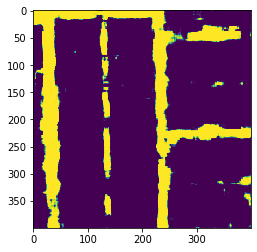

In [12]:
plt.imshow(pred.detach().numpy())

In [13]:
import cv2
from torch_unet.post_processing import post_process_prediction
for b in test_loader:
    preds = net(b['image'])
    
    img = (torch.sigmoid(preds)[0][0].detach().numpy() > 0.5) * 1
    img = cv2.resize(img.astype('uint8'), (608, 608), interpolation=cv2.INTER_LINEAR)
    #img = post_process_prediction(img)
    mpimg.imsave(DEST_DIR + b['id'][0] + ".png", img)

In [10]:
import pandas as pd

In [25]:
submission = pd.read_csv("../Datasets/submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])
merged = submission.merge(solution, on='id')

In [26]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)]['id'].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)]['id'].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)]['id'].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [27]:
f1_score, precision, recall

(0.6971765368697047, 0.6024191132414619, 0.8273077912059655)

In [28]:
def input_size_needed(output_size, num_layers):
    for i in range(num_layers - 1):
        assert output_size % 2 == 0, 'expand layer {} has size {} not divisible by 2' \
            .format(num_layers - i, output_size)
        output_size = (output_size + 4) / 2

    for i in range(num_layers - 1):
        output_size = (output_size + 4) * 2

    return int(output_size + 4)

In [33]:
input_size = input_size_needed(388, 5)

In [34]:
offset = int((input_size - 388) / 2)

In [58]:
input_size

572

In [46]:
height, width, _ = img.shape

In [127]:
for i in range(15, 90, 15):
    print(rotate_image(img, i).shape)

(489, 489, 3)
(546, 546, 3)
(565, 565, 3)
(546, 546, 3)
(489, 489, 3)


In [135]:
a = np.array([1,2,3,4])
np.pad(a, (2,2), mode='symmetric')

array([2, 1, 1, 2, 3, 4, 4, 3])

In [137]:
offset = 572 - 388
h = 400
p = int(np.ceil((h/2) * (np.sqrt(2) - 1) + np.sqrt(2) * offset))

In [143]:
np.sqrt(2*(584/2)**2)

412.95036021294374

In [146]:
(int(np.sqrt(4))-1) * 12 + 388

400

In [47]:
output_size = height + 2 * offset
padding = int(np.ceil(height * (np.sqrt(2) - 1) / 2)) + int(np.ceil(offset / np.sqrt(2)))

In [156]:
5 // 4, 5%4

(1, 1)

In [50]:
def mirror_border(image, n):
    has_channels = (len(image.shape) == 3)
    if has_channels:
        return np.pad(image, ((n, n), (n, n), (0, 0)), "symmetric")
    else:
        return np.pad(image, ((n, n), (n, n)), "symmetric")

In [51]:
t = mirror_border(img, padding)

In [59]:
from torch_unet.image_utils import rotate_image
t = rotate_image(t, 15)

In [133]:
2*400/np.sqrt(2)

565.6854249492379

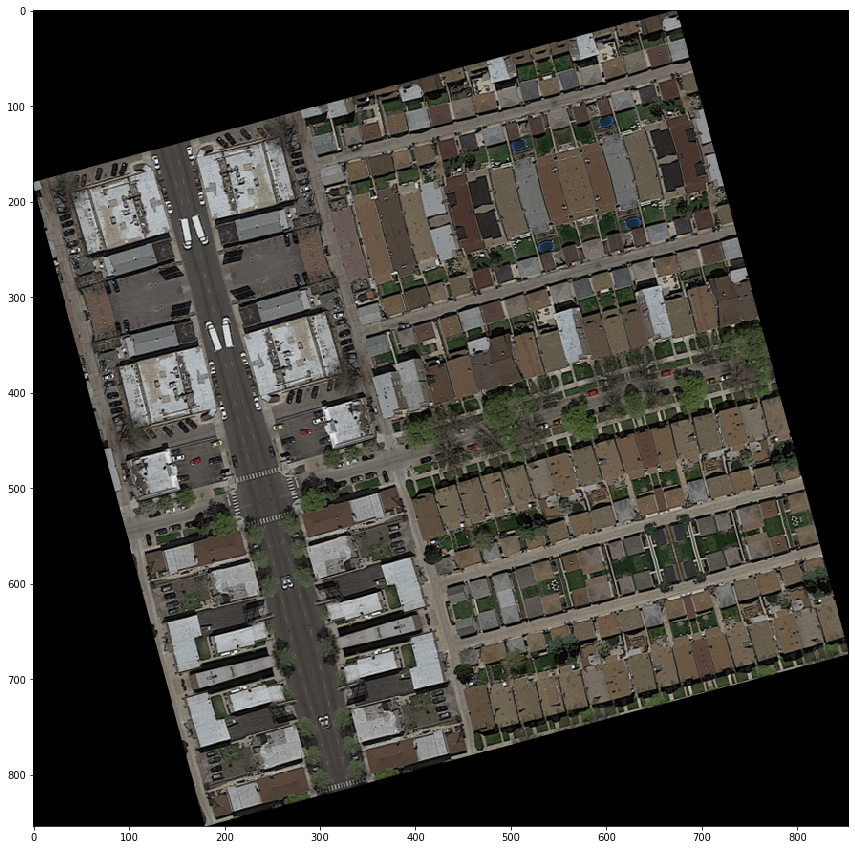

In [60]:
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(t)

In [67]:
def crop_imgs(imgs, crop_size):
    batch_size, height, width = imgs.shape[:3]
    half_crop = int(crop_size / 2)
    center = int(height / 2)

    has_channels = (len(imgs.shape) == 3)
    if has_channels:
        croped = imgs[center - half_crop:center + half_crop, center - half_crop:center + half_crop, :]
    else:
        croped = imgs[:, center - half_crop:center + half_crop, center - half_crop:center + half_crop]

    return croped

In [68]:
cropped = crop_imgs(t, output_size)

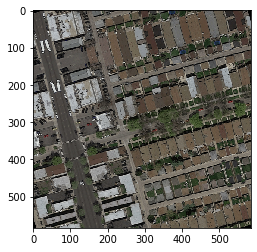

In [70]:
plt.imshow(cropped)

In [110]:
def extract_patches(images, patch_size, stride=None, predict_patch_size=None):
    """extract square patches from a batch of images
    images:
        4D [num_images, image_height, image_width, num_channel]
        or 3D [num_images, image_height, image_width]
    patch_size:
        should divide the image width and height
    predict_patch_size:
        inside image than would need to be predicted (no mirror)
    returns:
        4D input: [num_patches, patch_size, patch_size, num_channel]
        3D input: [num_patches, patch_size, patch_size]
    """
    if not predict_patch_size:
        predict_patch_size = patch_size

    assert (patch_size - predict_patch_size) % 2 == 0 and predict_patch_size <= patch_size
    predict_patch_offset = int((patch_size - predict_patch_size) / 2)

    if not stride:
        stride = patch_size

    has_channels = (len(images.shape) == 3)

    image_height, image_width, _ = images.shape
    assert image_height == image_width, "Assume square images"
    assert (image_height - patch_size) % stride == 0, "Stride sliding should cover the whole image"

    # expanded_size = image_width + 2 * predict_patch_offset
    # expanded_images = mirror_border(images, predict_patch_offset)

    patches_per_side = int((image_height - patch_size) / stride) + 1
    num_patches = patches_per_side * patches_per_side

    if has_channels:
        patches = np.zeros((num_patches, patch_size, patch_size, images.shape[-1]))
    else:
        patches = np.zeros((num_patches, patch_size, patch_size))

    patch_idx = 0
    for x in range(0, image_width - patch_size + 1, stride):
        for y in range(0, image_height - patch_size + 1, stride):
            if has_channels:
                patches[patch_idx] = images[y:y + patch_size, x:x + patch_size, :]
            else:
                patches[patch_idx] = images[y:y + patch_size, x:x + patch_size]

            patch_idx += 1

    return patches

In [111]:
patches = extract_patches(cropped, input_size, predict_patch_size=388, stride=12)

In [119]:
np.sum(patches[0] == patches[1]) == 12 * 

192

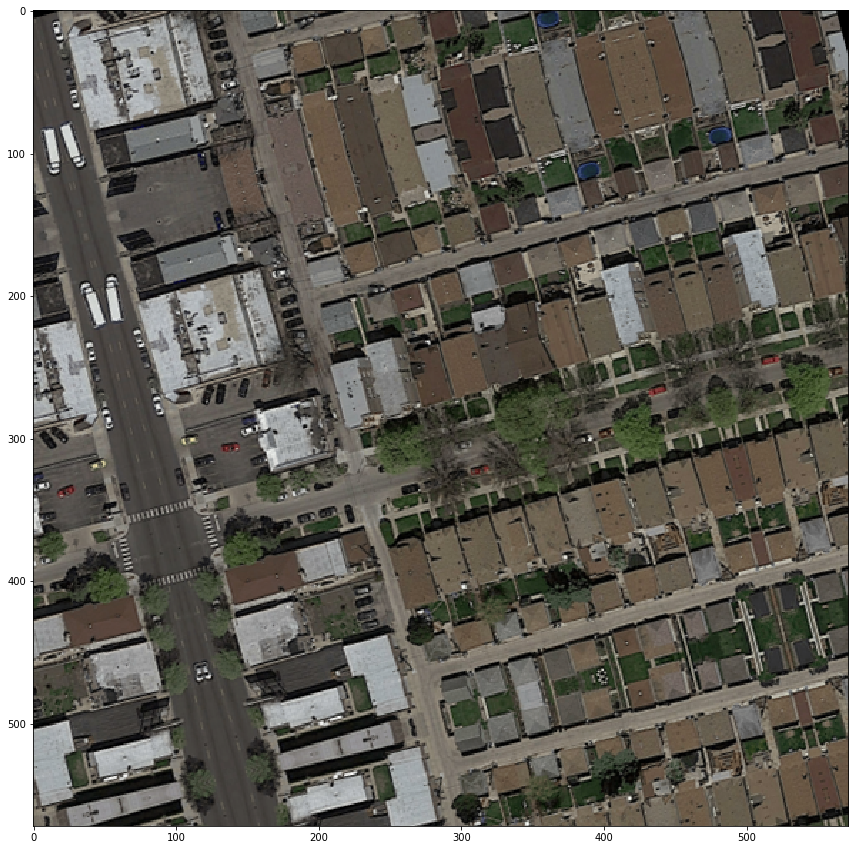

In [122]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(patches[2])